In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
!pip install -U fastai

     |████████████████████████████████| 194kB 5.5MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
from fastai.vision.all import *

In [4]:
#importing the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd drive/My\ Drive

/content/drive/My Drive


In [6]:
root_path = Path('.')
data_path = Path('surfacique_no_ss_class')
model_path = Path('Models')

In [7]:
size = 512
lr = defaults.lr
bs = 32

In [8]:
batch_transforms = aug_transforms(mult=1.0,
                                  do_flip=True,
                                  flip_vert=True,
                                  max_rotate=2.0, 
                                  min_zoom=1.0,
                                  max_zoom=1.0,
                                  max_lighting=0.2,
                                  max_warp=0.2,
                                  p_affine=0.75, 
                                  p_lighting=0.75,
                                  xtra_tfms=None,
                                  size=size,
                                  mode='bilinear',
                                  pad_mode='zeros',
                                  align_corners=True, 
                                  batch=True,
                                  min_scale=1.0)

db = DataBlock(blocks = (ImageBlock, CategoryBlock),
               get_items = get_image_files,
               splitter = RandomSplitter(valid_pct=0.2, seed=1),
               get_y = parent_label,
               item_tfms = Resize(size),
              #  batch_tfms = [*batch_transforms, Normalize()]
               )

data = db.dataloaders(data_path, bs=bs)
# data.show_batch(max_n=20)


In [9]:
print(len(data.train_ds))
print(len(data.valid_ds))

3956
989


In [10]:
learner = cnn_learner(data,
                      resnet50,
                      metrics = error_rate,
                      pretrained = True,
                      wd_bn_bias = False,
                      loss_func = LabelSmoothingCrossEntropy(),
                      cbs = [BnFreeze,
                              SaveModelCallback(monitor='error_rate', fname='best_error'),
                              ShowGraphCallback],
                      model_dir = model_path
                      ).to_fp16()


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [11]:
learner.load('stage-2');

In [12]:
# learner = load_learner("Models/archeo_bw.pkl")

In [13]:
@classmethod
def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
    "Construct interpretatio object from a learner"
    if dl is None: dl = learn.dls[ds_idx]
    preds, targs, decoded, losses = learn.get_preds(dl=dl, with_input=False, with_loss=True, with_decoded=True, act=None)
    return cls(dl, [], preds, targs, decoded, losses)

In [14]:
interp = ClassificationInterpretation.from_learner(learner)

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


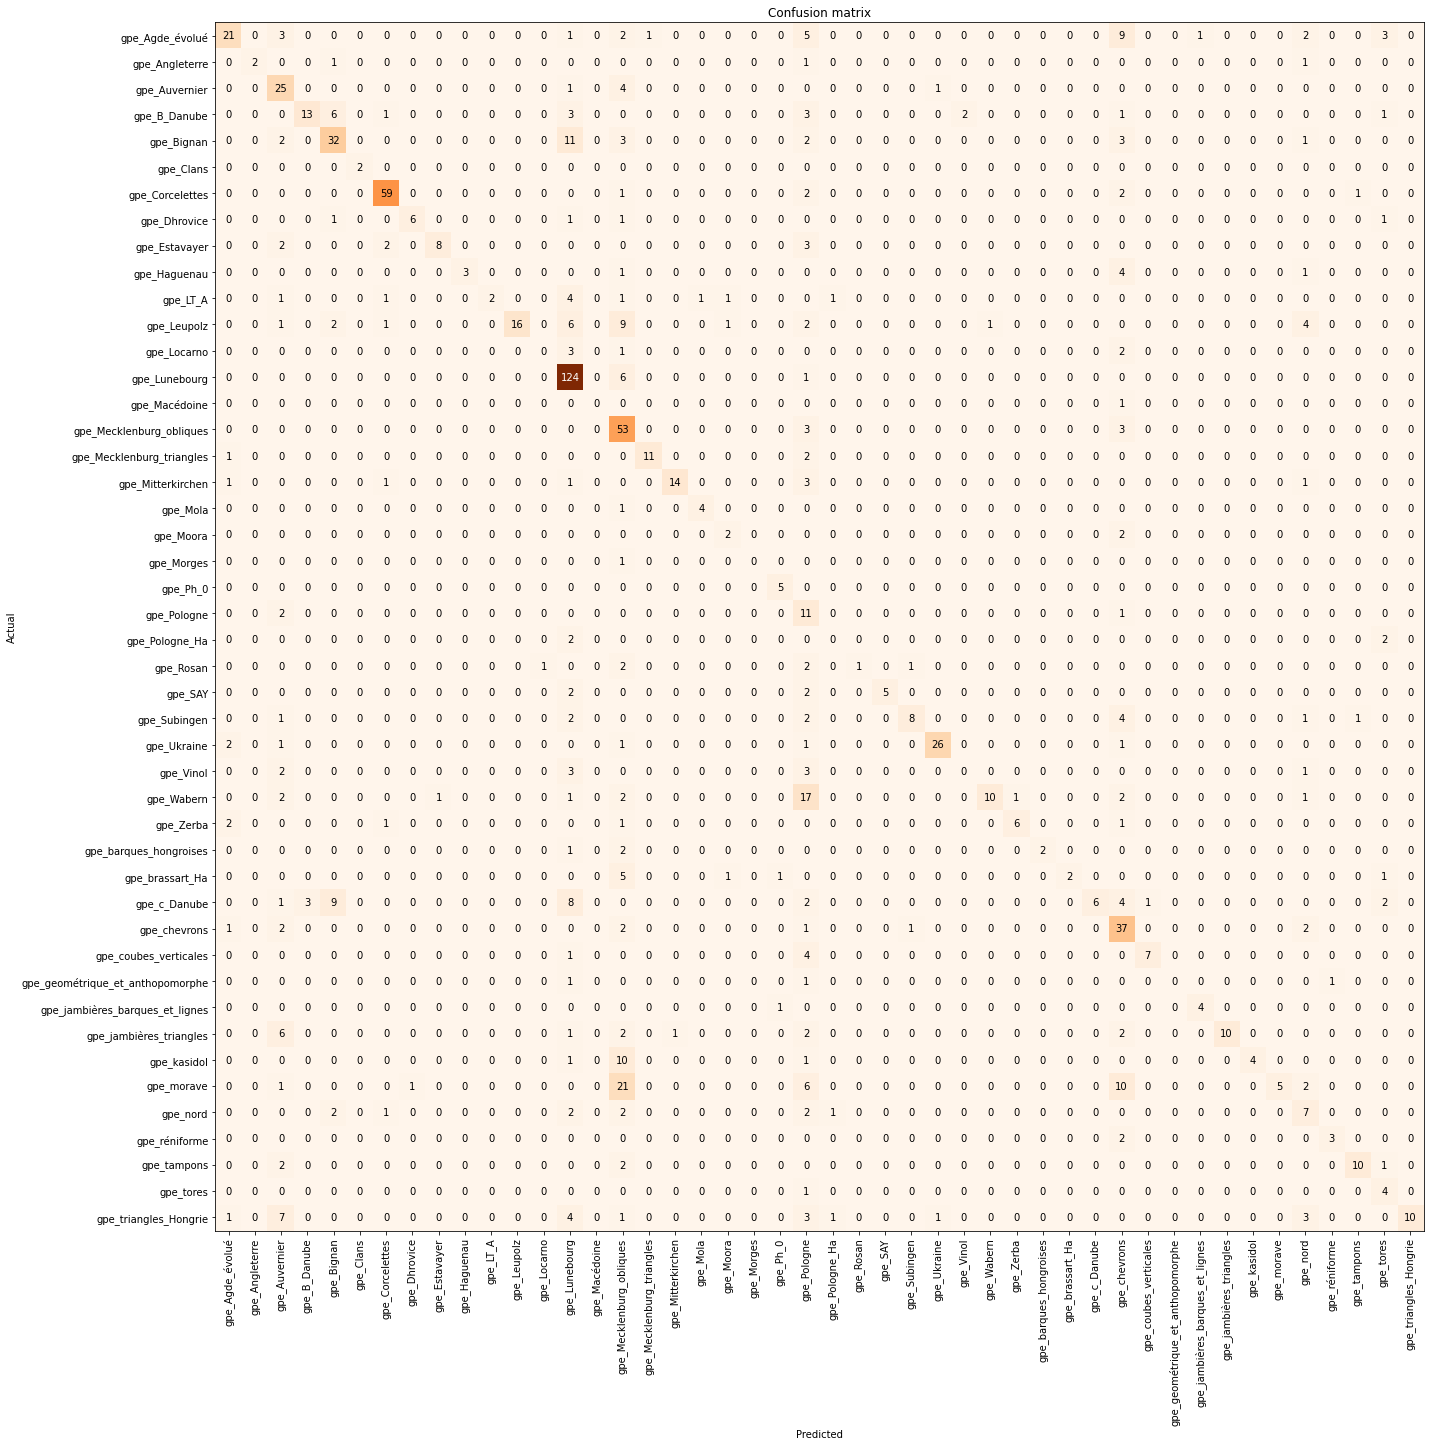

In [33]:
interp.plot_confusion_matrix(normalize = False,figsize=(20,20), cmap="Oranges")
plt.savefig("confusion.png")

In [29]:
interp.print_classification_report()

                                   precision    recall  f1-score   support

                gpe_Agde_évolué       0.72      0.44      0.55        48
                   gpe_Angleterre       1.00      0.40      0.57         5
                    gpe_Auvernier       0.41      0.81      0.54        31
                     gpe_B_Danube       0.81      0.43      0.57        30
                       gpe_Bignan       0.60      0.59      0.60        54
                        gpe_Clans       1.00      1.00      1.00         2
                  gpe_Corcelettes       0.88      0.91      0.89        65
                     gpe_Dhrovice       0.86      0.60      0.71        10
                    gpe_Estavayer       0.89      0.53      0.67        15
                     gpe_Haguenau       1.00      0.33      0.50         9
                         gpe_LT_A       1.00      0.17      0.29        12
                      gpe_Leupolz       1.00      0.37      0.54        43
                      gp

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
interp.plot_top_losses(k = 40, largest=True, figsize=(50,50))

Output hidden; open in https://colab.research.google.com to view.